<a href="https://colab.research.google.com/github/terrysu64/computer-vision-bootcamp/blob/master/cv_bootcamp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR10 Classification

In [1]:
!nvidia-smi

Mon Aug  1 13:55:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import Libraries

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

### Download Datasets

In [3]:
dataset = CIFAR10(root='data/', 
                  download=True, 
                  transform=ToTensor()) #ToTensor() normalizes the data on download

Files already downloaded and verified


In [4]:
dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()

## Split Into Train/Validation Sets

In [5]:
torch.manual_seed(42) #set seed to replicate results
val_size = len(dataset)//10
train_size = len(dataset) - val_size

In [6]:
train_ds, val_ds = random_split(dataset, [train_size, val_size]) #randomly split dataset into training/validation sets
len(train_ds), len(val_ds)

(45000, 5000)

In [7]:
batch_size=32 #we will pass 32 and 64 images at once for training and validation respectively
train_loader = DataLoader(train_ds, 
                          batch_size, 
                          shuffle=True, #randomizes image sequence
                          num_workers=4, 
                          pin_memory=True) #allows us to push images from CPU -> GPU later
val_loader = DataLoader(val_ds, 
                        batch_size*2, 
                        num_workers=4, 
                        pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### Setting Up The Model

In [8]:
def accuracy(outputs, labels):
    """returns accuracy of predictions by comparing outputs with labels"""

    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item()) / len(preds)
  
def evaluate(model, val_loader):
    """evaluate model on validation set"""

    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """trains the model for a number of epochs, given an optimizing function and learning rate"""
    
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        for batch in train_loader:
            loss = model.training_step(batch); loss.backward()
            optimizer.step(); optimizer.zero_grad()
        res = evaluate(model, val_loader)
        model.epoch_end(epoch, res)
        history += [res]
    return history

In [9]:
class Baseline(nn.Module):
    def training_step(self, batch):
        """trains the model on a batch of the training set"""

        images, labels = batch 
        out = self(images)                  #generate predictions
        loss = F.cross_entropy(out, labels) #calculate loss (similar to categorical_crossentropy in tensorflow)
        return loss
    
    def validation_step(self, batch):
        """trains the model on a batch of the validation set"""

        images, labels = batch 
        out = self(images)                    #generate predictions
        loss = F.cross_entropy(out, labels)   #calculate loss
        acc = accuracy(out, labels)           #calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        """return summary of metrics after validation has finished"""

        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   #combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      #combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print(f"Epoch [{epoch}], \
              validation loss: {round(result['val_loss'], 4)}, \
              validation accuracy: {round(result['val_acc'], 4)}")

In [10]:
class CNNModel(Baseline):
    """
    define a typical architecture of a convolutional neural network
    https://poloclub.github.io/cnn-explainer/
    
    nn.Conv2d => Sum of all kernel results + bias
    nn.MaxPool2d => summarizing image (extracting significant features) by taking max values a particular patch of the image 
    """

    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), #dense layer for three different color channels
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #size => 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #size => 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #size => 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)) #dense layer for 10 possible answers
        
    def forward(self, xb):
        return self.network(xb)

### Setting Up GPU

In [11]:
def to_device(data, device):
    """move data to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """number of batches"""
        return len(self.dl)

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') #choose to switch to GPU if possible
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

### Training Model

In [13]:
history = []
model = to_device(CNNModel(), device)
epochs, learning_rate = 7, 0.1
history += fit(epochs, learning_rate, model, train_loader, val_loader) #fit the model

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0],               validation loss: 2.3024,               validation accuracy: 0.1017
Epoch [1],               validation loss: 2.8384,               validation accuracy: 0.2126
Epoch [2],               validation loss: 1.5212,               validation accuracy: 0.4452
Epoch [3],               validation loss: 1.4184,               validation accuracy: 0.5273
Epoch [4],               validation loss: 1.1604,               validation accuracy: 0.5955
Epoch [5],               validation loss: 0.9987,               validation accuracy: 0.662
Epoch [6],               validation loss: 1.2149,               validation accuracy: 0.6228


### Evaluating Model

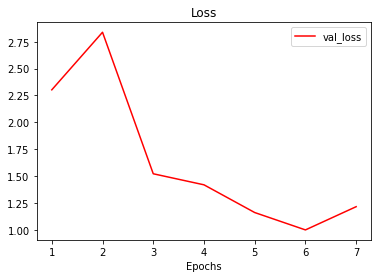

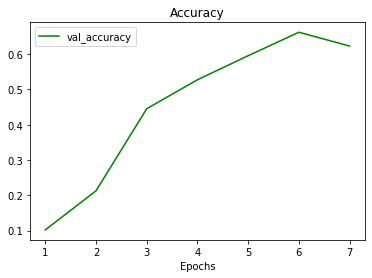

In [15]:
def plot_curves(history,epochs=7):
  """graphs the accuracy and loss curves of the valisation set"""

  val_loss = [x['val_loss'] for x in history]
  val_accuracy = [x['val_acc'] for x in history]

  epochs = [i for i in range(1,epochs+1)]

  #plot loss
  plt.plot(epochs, val_loss, label='val_loss', color="r")
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  #plot accuracy
  plt.figure()
  plt.plot(epochs, val_accuracy, label='val_accuracy', color="g")
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

plot_curves(history, epochs) 

